In [ ]:
import pandas as pd
import numpy as np
import keras
from keras import layers

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

**Copied from Part 1:**
This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels_pd = pd.read_csv("/content/drive/MyDrive/labels.csv")
counts_pd = pd.read_csv("/content/drive/MyDrive/processed_counts.csv")

In [ ]:
labels_pd.index = labels_pd['index']
labels_pd.drop("index", axis=1, inplace=True)
counts_pd.index = counts_pd['Unnamed: 0']
counts_pd.drop("Unnamed: 0", axis=1, inplace=True)

df = counts_pd.merge(labels_pd, left_index=True, right_index=True).dropna()
df

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,NECAP2,HP1BP3,C1QA,C1QB,HNRNPR,GALE,STMN1,CD52,FGR,ATPIF1,SESN2,EIF3I,LCK,MARCKSL1,SFPQ,PSMB2,MEAF6,NDUFS5,CAP1,SMAP2,C1orf228,PRDX1,TMEM69,SCP2,MAGOH,JAK1,CCBL2,GBP2,CD53,DENND2D,...,ZNF600,ZNF524,CTD-3138B18.5,ATP6V1E1,BID,MRPL40,UFD1L,COMT,DGCR6L,SDF2L1,IGLL5,IGLL1,CHCHD10,SMARCB1,MIF,ASCC2,PIK3IP1,HMOX1,EIF3D,IL2RB,LGALS2,EIF3L,ADSL,RBX1,TTC38,TYMP,CCT8,SOD1,PAXBP1,ATP5O,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,bulk_labels
AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,-0.525,1.804,0.578,-0.198,1.266,-0.192,-0.307,0.048,-0.606,0.478,-0.07,-0.864,-0.534,-0.504,-0.509,-0.727,-0.646,0.336,-0.017,4.381,-0.251,0.235,-0.252,-0.701,-0.537,-0.684,-0.244,-0.421,0.575,-0.375,...,-0.109,-0.402,-0.122,-0.583,-0.690,-0.487,-0.582,-0.630,-0.507,0.697,-0.133,-0.062,1.777,0.948,0.436,-0.345,-0.418,0.652,0.351,-0.196,-0.413,-0.323,-0.491,-0.719,-0.205,-0.092,-0.694,-0.070,-0.116,-0.146,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011,CD14+ Monocyte
AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,1.287,-0.420,0.954,2.367,1.170,-0.192,-0.307,0.266,0.629,-0.802,-0.07,-0.864,-0.534,0.873,-0.509,0.645,-0.646,0.274,0.856,1.845,-0.251,-0.796,-0.252,-0.701,1.581,-0.684,-0.244,-0.421,-0.282,-0.375,...,-0.109,-0.402,-0.122,-0.583,2.992,1.327,-0.582,0.991,-0.507,0.636,-0.133,-0.062,-0.687,-0.497,0.373,-0.345,-0.418,-0.366,1.496,-0.196,-0.413,0.478,-0.491,-0.719,-0.205,1.089,-0.694,-0.120,-0.116,-1.136,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490,Dendritic
AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,-0.525,1.258,-0.310,-0.198,-0.602,-0.192,-0.307,-0.462,1.358,-0.802,-0.07,0.205,-0.534,-0.504,-0.509,0.364,-0.646,-0.881,-0.256,-0.445,-0.251,-0.796,-0.252,0.480,2.831,1.528,-0.244,0.816,-0.440,1.583,...,-0.109,-0.402,-0.122,-0.583,-0.690,-0.487,-0.582,-0.630,-0.507,-0.502,-0.133,-0.062,-0.687,-0.497,-0.782,-0.345,-0.418,-0.366,0.037,5.397,-0.413,0.131,1.310,-0.719,-0.205,-0.733,1.747,0.428,-0.116,-1.136,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490,CD56+ NK
AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,-0.525,9.900,-0.310,-0.198,1.565,-0.192,2.270,1.258,-0.606,-0.802,-0.07,-0.864,0.741,-0.504,2.193,2.630,1.627,-0.881,-0.990,-0.445,-0.251,-0.796,-0.252,1.114,-0.537,-0.684,-0.244,1.481,2.728,-0.375,...,-0.109,-0.402,-0.122,-0.583,-0.690,-0.487,-0.582,-0.630,-0.507,-0.502,-0.133,-0.062,-0.687,-0.497,-0.782,-0.345,-0.418,-0.366,2.036,-0.196,-0.413,-0.180,-0.491,-0.719,-0.205,-0.733,-0.694,1.221,-0.116,1.161,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490,CD4+/CD25 T Reg
ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,-0.525,1.046,-0.310,-0.198,0.630,-0.192,-0.307,-0.546,1.110,1.730,-0.07,1.005,-0.534,-0.504,-0.509,-0.727,-0.646,-0.881,0.293,-0.445,-0.251,-0.796,-0.252,1.363,2.407,0.283,-0.244,-0.421,-0.518,-0.375,...,-0.109,-0.402,-0.122,-0.583,-0.690,-0.487,-0.582,-0.630,-0.507,-0.502,-0.133,-0.062,-0.687,-0.497,0.824,-0.345,-0.418,0.306,-0.926,-0.196,3.847,1.138,-0.491,0.213,-0.205,-0.310,-0.694,-1.048,-0.116,-1.136,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490,Dendritic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGGCACCTCCAACA-8,-0.326,-0.191,0.372,-0.584,-0.174,0.509,-0.451,2.160,-0.459,0.751,-0.525,-0.420,-0.310,0.265,-0.602,-0.192,-0.307,-1.127,-0.606,-0.802,-0.07,0.107,-0.534,2.478,-0.509,0.264,0.696,-0.881,1.676,-0.445,-0.251,-0.796,-0.252,-0.701,-0.537,1.324,-0.244,-0.421,-0.497,-0.375,...,-0.109,-0.402,-0.122,-0.583,0.639,-0.487,-0.582,-0.630,-0.507

One-hot encode the cell-type.

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [ ]:
categories = df['bulk_labels'].unique()
print(categories)

#one-hot encoding
y = np.zeros((len(df), len(categories)))
for i in range(len(df)):
  cell_type = df.iloc[i]['bulk_labels']
  pos = np.where(categories == cell_type)[0]
  y[i, pos] = 1

#remove label when processing input data
X = df.drop('bulk_labels', axis=1).values

#shufle and 80:20 split
np.random.seed(100)
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]

['CD14+ Monocyte' 'Dendritic' 'CD56+ NK' 'CD4+/CD25 T Reg' 'CD19+ B'
 'CD8+ Cytotoxic T' 'CD4+/CD45RO+ Memory' 'CD8+/CD45RA+ Naive Cytotoxic'
 'CD4+/CD45RA+/CD25- Naive T' 'CD34+']


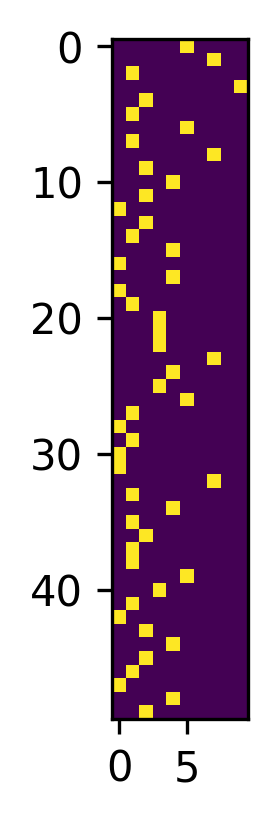

In [ ]:
#Visualize the One-hot encoded Prediction Labels
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3), dpi=300)
plt.imshow(y_train[:50])

Apply classification algorithms to the training data, tune on validation data (if present), and evaluate on test data.

You can also apply classification downstream of last week's autoencoder latent space representation.

In [ ]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score

In [ ]:
# take a random sample of the training data with replacement

def training_sample(n):

  cell_bc = [i for i in range(len(X_train))]
  rand = random.choices(cell_bc, k=n)

  mini_counts = [X_train[i] for i in rand]
  mini_labels = [y_train[i] for i in rand]

  return mini_counts, mini_labels

In [ ]:
# Decision Tree with Bagging 
# Because we are taking the aggregate of the results/using a BAGGING approach,
# we can just implement a very simple model (50% accuracy is good)

predictions = []

max_iter = 100

i=0

while len(predictions) < 15 or i != max_iter:
  # take a random sample of the data with replacement
  sample_X, sample_Y = training_sample(300)

  # create a multiout regressor with a random forest classifier  
  forest = DecisionTreeClassifier(criterion='entropy', max_depth=None)
  multiout_regressor = MultiOutputRegressor(forest, n_jobs=5)

  # train the classifier
  multiout_regressor.fit(sample_X, sample_Y)

  # test on the data
  y_pred = multiout_regressor.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)  

  print('iter: ', i, ' accuracy: ', accuracy)
  #if the accuracy of this model is above a certain threshold, keep this prediction:
  if accuracy >= 0.6:
    predictions.append(y_pred)

  i += 1

iter:  0  accuracy:  0.5642857142857143
iter:  1  accuracy:  0.5642857142857143
iter:  2  accuracy:  0.5071428571428571
iter:  3  accuracy:  0.55
iter:  4  accuracy:  0.5571428571428572
iter:  5  accuracy:  0.5214285714285715
iter:  6  accuracy:  0.6357142857142857
iter:  7  accuracy:  0.5714285714285714
iter:  8  accuracy:  0.5214285714285715
iter:  9  accuracy:  0.6214285714285714
iter:  10  accuracy:  0.5428571428571428
iter:  11  accuracy:  0.4785714285714286
iter:  12  accuracy:  0.5571428571428572
iter:  13  accuracy:  0.55
iter:  14  accuracy:  0.6285714285714286
iter:  15  accuracy:  0.5428571428571428
iter:  16  accuracy:  0.5142857142857142
iter:  17  accuracy:  0.5928571428571429
iter:  18  accuracy:  0.5071428571428571
iter:  19  accuracy:  0.5214285714285715
iter:  20  accuracy:  0.5571428571428572
iter:  21  accuracy:  0.5214285714285715
iter:  22  accuracy:  0.6428571428571429
iter:  23  accuracy:  0.6
iter:  24  accuracy:  0.5785714285714286
iter:  25  accuracy:  0.5357

In [ ]:
# now to finish the classification, take the aggregate of the results to 
# determine the classification

classification = []

for cell in range(len(y_test)):
  preds = predictions[0][cell]

  #get all the predictions for this cell
  for pred in predictions[1:]:
    preds = np.add(preds, pred[cell])
  
  # now take the index of the max value in the list
  # this means that out of all the iterations, this
  # was the most common prediction

  classify = np.zeros(10)
  max = np.max(preds)
  index = list(preds).index(max)

  classify[index] = 1

  classification.append(classify)
  

# now from our final predictions, test the accuracy
acc = accuracy_score(y_test, classification)

print('final accuracy: ', acc)

final accuracy:  0.8285714285714286


Write up:

For this classification assignment, I decided to implement a BAGGING approach with a decision tree as my classifier. I decided to use a regular decision tree classifier model initially but found it hard to get the accuracy to be more than 61% even after playing around with the parameters. So I decided run multiple decision tree models and apply a BAGGING approach. By doing this, even if the individual parallel classifiers are not very good models, the aggregate of these classifiers will be much more robust. I also used a multiple output regressor on top of the classification tree since there are multiple classes/output. I also found that the classification tree performed better when the max_depth parameter was not set. For every iteration (with a maximum iteration limit of 100), I take a smaller sample of the training data and use that to train the model. If the accuracy of that model is more than or equal to 60%, I store the predictions. Because I'm using a BAGGING approach, a lower accuracy threshold for every iteration is okay in this case since I will be using the aggregate of the results anyway. After I have about 15 predictions with an accuaracy of at least 60%, I look through the prediction for every cell and take the most common prediction. In other words, I find the position of where the majority of the 1's are from all the stored predictions and use that as my final classification. With this impelementation that I just described, my final accuracy score is about 83%.